In [320]:
from bs4 import BeautifulSoup
%matplotlib inline
import requests
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab as pl
plt.style.available
plt.style.use('bmh')

# Web Scraping
For both questions, we will first need to extract the relevant dataset from the IS-Academia website. 
The function `mine_data(year, semester)` will generate a DataFrame containing the table for the given year and semester with an additional column named `Semester_year`. The returned DataFrame is indexed by `No Sciper` and  `Nom Prénom`. 
The data is retrieved from the HTML page using BeautifulSoup. For the details, look at the comments in the `get_table(soup, year, semester)` function.

PostMan has been used to get the corresponding parameters to generate the HTTP requests.

In [321]:
years = {
	'2007': '978181',
	'2008': '978187',
	'2009': '978195',
	'2010': '39486325',
	'2011': '123455150',
	'2012': '123456101',
	'2013': '213637754',
	'2014': '213637922',
	'2015': '213638028',
	'2016': '355925344'
}

semesters = {
	'B1': '249108',
    'B5': '942120',
	'B6': '942175',
	'M1': '2230106',
    'M2': '942192',
	'M3': '2230128',
	'PMAut': '249127',
	'PMSpr': '3781783'
}

In [322]:
def get_url(year, semester):
    """Get the url corresponding to a given year and semester"""
    y, sem = years[year], semesters[semester]
    return 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD='+ y +'&ww_x_PERIODE_PEDAGO=' + sem + '&ww_x_HIVERETE=null'

def request(year, semester):
    """return the http request corresponding to a given year and semester"""
    url = get_url(year, semester)
    return requests.get(url, verify=False)

def get_soup(year, semester):
    """return the data soup (BeautifulSoup) corresponding to a given year and semester"""
    r = request(year, semester)
    data = r.text
    return BeautifulSoup(data,"lxml")


def get_table(soup, year, semester):
    """Transform the data soup into a dict containing the data frame
    The dataframe contains all the columns returned by the html page + the index + column "Semester_year"
    """
    table = soup.html.body.table ##get to the table
    tc = table.children ##every rows of the table
    first_row = next(tc, None)
    attrs = first_row.text.split(',') ##extract the attributes from the header row
    nb_student = int(attrs[2].split("(")[1].split(" ")[0])
    if nb_student != 0: ##next row should contain columns info (except if there is no student)
        next_row = next(tc, None) ##directly iterate our iterator the next row
        columns = list(map(lambda l: l.text, next_row.children)) ##transform the children into a list of the inner text of each children
        df = pd.DataFrame(columns=columns) ##create the data frame with the columns from this list

        for c in tc:
            t = list(map(lambda l: l.text, c.children))[:-1] ##transform the children into a list of the inner text of each children (corresponding here to each column)
            df.loc[df.shape[0]] = t ##append the data to the last dataframe created

        sciper_c = columns[-1]
        df = df.set_index([sciper_c, 'Nom Prénom'])
        df[semester+'_year'] = year 
    
        return df
    return pd.DataFrame()

def mine_data(year, semester):
    soup = get_soup(year, semester) ##get the soup
    return get_table(soup, year, semester) ##process the soup


# Question 1
### Get the combined DataFrame of all students from 2007 until 2017
We will get the data of the first, fifth and sixth semester for each year (the fifth semester is included because students can finish their bachelor's degree in an autumn semester, which would then be entered as the fifth one again). The DataFrames are merged whilst retrieving each year in the following way: the `B1_year` entry is overridden only if it is not in the DataFrame yet. The `B5_year` and `B6_year` are overwritten every time a new value is found in a more recent year. In fact, to compute the time spent by a student during its Bachelor cycle, we will look at its last entry (either B5 or B6) and its first entry (B1).

In [323]:
df_bachelor =  mine_data('2007', 'B1') # Just to instantiate the first DataFrame
df_bachelor['B5_year'] = float('NaN')
df_bachelor['B6_year'] = float('NaN') # Because nan can only be stored in floating points

for year in range(2007, 2017):
    df_b1 = mine_data(str(year), 'B1')
    #override only if B1 entry is not in the dataframe yet
    df_bachelor = df_bachelor.combine_first(df_b1)
    
    #override the date when newer semester found
    df_b6 = mine_data(str(year), 'B6')
    df_b5 = mine_data(str(year), 'B5')
    df_bachelor.update(df_b6)
    df_bachelor.update(df_b5)

In [324]:
df_bachelor.head(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2010,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
161212,Tamesna Rachid,2009,NaN,NaN,Monsieur,,,,,,,Présent,
169569,Arévalo Christian,2007,2009,2009,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2010,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2010,Monsieur,,,,,,,Présent,
170509,Grall Jean-Louis,2007,NaN,NaN,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2009,Monsieur,,,,,,,Présent,
171568,Villavicencio Omar,2007,NaN,NaN,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2009,Monsieur,,,,,,,Présent,


### Keep students who completed  their Bachelor Degree
We are interested in the students who have completed their Bachelor degree, so they need to have an entry in B1 and an entry in B6.

In [325]:
df_bachelor = df_bachelor.dropna(subset=['B1_year', 'B6_year'])
df_bachelor.head(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2010,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
169569,Arévalo Christian,2007,2009,2009,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2010,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2010,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2009,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2009,Monsieur,,,,,,,Présent,
174905,Aubelle Flavien,2007,2011,2011,Monsieur,,,,,,,Présent,
175190,Hanser Valérian,2007,2010,2009,Monsieur,,,,,,,Présent,
175280,Uberti Quentin,2007,2010,2010,Monsieur,,,,,,,Présent,


Bachelor 6 is actually in the spring semester so one year after

In [326]:
df_bachelor[['B6_year']] = df_bachelor[['B6_year']].apply(pd.to_numeric)
df_bachelor['B6_year'] = df_bachelor['B6_year'] + 1

In [327]:
df_bachelor.head(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2011,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
169569,Arévalo Christian,2007,2009,2010,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2011,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2011,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2010,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2010,Monsieur,,,,,,,Présent,
174905,Aubelle Flavien,2007,2011,2012,Monsieur,,,,,,,Présent,
175190,Hanser Valérian,2007,2010,2010,Monsieur,,,,,,,Présent,
175280,Uberti Quentin,2007,2010,2011,Monsieur,,,,,,,Présent,


### Compute the number of months spent by a student during its Bachelor degree
We add the cell `bachelor_months` to the DataFrame.


In [328]:
def compute_time(df):
    #if the student finishes in the fifth semester, it has done six more months 
    if float(df['B5_year']) >= float(df['B6_year']):
        end = float(df['B5_year']) + 0.5
    #otherwise he finishes in the summer
    else:
        end = float(df['B6_year'])
    # We want to compute the total time spent in months
    # 1st semester is sep-jan, and 2nd feb-jul so count only 5 months to complete 1st.
    time = (end - float(df['B1_year'])) * 12 - 1 
    return time

In [329]:
df_bachelor['bachelor_months'] = df_bachelor.apply(compute_time, axis=1)

In [330]:
df_bachelor.head(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,bachelor_months
No Sciper,Nom Prénom,,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2011,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral,35.0
169569,Arévalo Christian,2007,2009,2010,Monsieur,,,,,,,Présent,,35.0
169731,Knecht Mathieu,2007,2010,2011,Monsieur,,,,,,,Congé,,47.0
169795,Scheiben Pascal,2007,2011,2011,Monsieur,,,,,,,Présent,,53.0
171195,Richter Arnaud,2007,2009,2010,Monsieur,,,,,,,Présent,,35.0
171619,Buchschacher Nicolas,2007,2009,2010,Monsieur,,,,,,,Présent,,35.0
174905,Aubelle Flavien,2007,2011,2012,Monsieur,,,,,,,Présent,,59.0
175190,Hanser Valérian,2007,2010,2010,Monsieur,,,,,,,Présent,,41.0
175280,Uberti Quentin,2007,2010,2011,Monsieur,,,,,,,Présent,,47.0


### Average time per gender
We simply need to group by `Civilité` to get the average time per gender

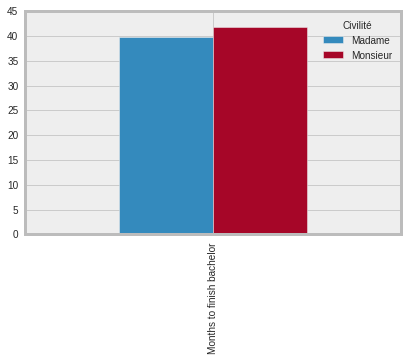

In [331]:
df_bachelor["Civilité"].astype('category')
sex_grouped = df_bachelor.groupby('Civilité')['bachelor_months']
b_months = sex_grouped.apply(np.average)
b_months.to_frame(name='Months to finish bachelor').unstack().unstack().plot.bar()

## Statistical significance
In order to evaluate the statistical significance of the difference in average between the male and female students, we first examine the data as a whole, with regard to the number of months spent to get one's bachelor degree.

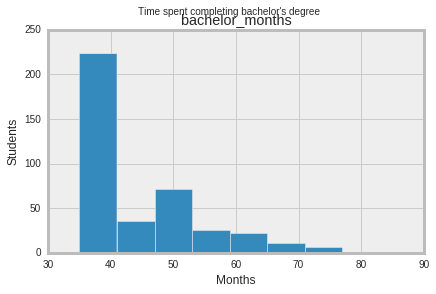

In [332]:
b_months_min = df_bachelor.bachelor_months.min().astype(int)
b_months_max = df_bachelor.bachelor_months.max().astype(int)
df_bachelor.hist(column='bachelor_months', bins=range(b_months_min, b_months_max+1, 6))
pl.suptitle("Time spent completing bachelor's degree")
pl.xlabel("Months")
pl.ylabel("Students")

As can be expected, most students complete the bachelor's in 36 months (the mandatory 3 years). A fair amount will need 6 or 12 months more. If we now look at the structure of the data by gender, we can see that it holds roughly the same shape in both cases.

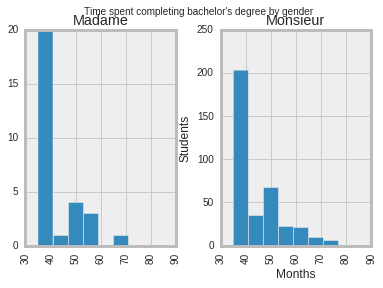

In [333]:
df_bachelor.hist(column='bachelor_months', by=df_bachelor['Civilité'], bins=range(b_months_min, b_months_max+1, 6))
pl.suptitle("Time spent completing bachelor's degree by gender")
pl.xlabel("Months")
pl.ylabel("Students")

### Test 1

Since we are observing a dependent variable (i.e. the n° of months to complete a bachelor's degree) in two population samples determined by an independent variable (i.e. the gender of the person), we use an **Mann-Whitney rank test **, as provided in `scipy`'s `mannwhitneyu` function. We do not use the unpaired two sample t-tests because our random variables, the number of months, are not randomly sampled from a normal distribution (number of month is not even continuous).

In [334]:
values_per_gender = [gender_value for gender_name, gender_value in sex_grouped]
stat, pval = stats.mannwhitneyu(*values_per_gender) 

So in this case, we're working with the null hypothesis $H_0$ that the mean in months spent for a bachelor's degree of the two populations, male and female students in computer science, is equal. 

With our two samples, we get the following p-value:

In [335]:
pval

0.10002116850072768

This is just above an $\alpha$ of 0.10. So the test indicates that we fail to reject the null Hypothesis $H_0$, i.e. that this difference in mean is *not obviously statistically significant*. But being at the limit, it is far from unlikely that the Madame takes less times to complete the Master.

### Test 2

As an additional test to avoid arbitrary inaccuracies of the t-test we used, we can try the K-S test on our two sample data distributions. This is a non-parametric test, and basically computes the max distance between the cumulative distribution functions of the two distributions. 

In [336]:
stat, pval = stats.ks_2samp(*values_per_gender)
pval

0.65225950107177355

Once again, the result of the test indicates that we should accept $H_0$. So we can state that the difference in the mean value between the number of months needed by women and men is not statistically significant.

# Question 2 

Get the data: same principle as Question 1.

In [337]:
df_master =  mine_data('2007', 'M1')
df_master['M1_year'] = float('NaN')
df_master['M2_year'] = float('NaN')
df_master['M3_year'] = float('NaN')
df_master['PMAut_year'] = float('NaN')
df_master['PMSpr_year'] = float('NaN')
df_master['Spécialisation'] = str('NaN')

for year in range(2007, 2017):
    df_m1 = mine_data(str(year), 'M1')
    #override only if M1 is not in the dataframe yet
    df_master = df_master.combine_first(df_m1)
    
    #override the date when older semester found
    df_m2 = mine_data(str(year), 'M2')
    df_m3 = mine_data(str(year), 'M3')
    df_p1 = mine_data(str(year), 'PMAut')
    df_p2 = mine_data(str(year), 'PMSpr')
    df_master.update(df_m2)
    df_master.update(df_m3)
    df_master.update(df_p1)
    df_master.update(df_p2)

In [338]:
df_master.head(10)

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,,,
138088,Droz-dit-Busset Arnault,Monsieur,,,2007.0,NaN,NaN,,,,NaN,NaN,NaN,Présent,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008,,,,NaN,NaN,,Présent,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012,,,,2010,2010,"Signals, Images and Interfaces",Présent,
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
147008,Good Xavier,Monsieur,,,2011.0,2012,2012,,,,NaN,NaN,,Présent,
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009,,,,NaN,NaN,Internet computing,Présent,
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
153762,Conus Johann,Monsieur,,,2008.0,2009,2009,,,,NaN,NaN,,Présent,


### Compute the time spent to finish the Master degree
We made the following assumptions in order to know if a student has finished his Master Degree: if he has no `Spécialisation` or `Mineur`, he needs to have an entry for the first and second semester. If he has a `Spécialisation` or a `Mineur`, he needs an entry for the third semester. We know that a Master Degree is obtained only if a Master Project has been done but it seems that there are many missing values so we will take it into account only if a value has been found.


In [339]:
# The empty strings are considered as NaN
df_master = df_master.replace('',np.nan)

In [340]:
# drop students not in M1 and M2
df_m = df_master.dropna(subset=['M1_year', 'M2_year'])
# drop students with Spécialisation or Mineur but no M3
df_m = df_m[(pd.isnull(df_m.M3_year) & pd.isnull(df_m.Spécialisation) & pd.isnull(df_m.Mineur)) | (~pd.isnull(df_m.M3_year) & ((~pd.isnull(df_m.Spécialisation) | (~pd.isnull(df_m.Mineur)))))]

We compute the difference between the last entry found and the first year

In [341]:
def compute_time_master(df):
    #if the student has done a master project 
    if (not pd.isnull(df['PMAut_year'])):
        end = float(df['PMAut_year']) + 0.5
    elif (not pd.isnull(df['PMSpr_year'])):
        end = float(df['PMSpr_year']) + 1
    elif (not pd.isnull(df['M3_year'])):
        end = float(df['M3_year']) + 0.5
    else:
        end = float(df['M2_year']) + 1
    time = 12*(float(end) - float(df['M1_year'])) - 1
    return time

In [342]:
df_m['master_months'] = df_m.apply(compute_time_master, axis=1)

In [343]:
df_m.head()

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange,master_months
No Sciper,Nom Prénom,,,,,,,,,,,,,,,
146742,Marx Clément,Monsieur,NaN,NaN,2008.0,2009,2012,NaN,NaN,NaN,2010,2010,"Signals, Images and Interfaces",Présent,NaN,29.0
146929,Junod Antoine,Monsieur,NaN,NaN,2007.0,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Présent,NaN,11.0
152232,Anagnostaras David,Monsieur,NaN,NaN,2007.0,2007,2008,"Mineur en Management, technologie et entrepren...",NaN,NaN,NaN,NaN,NaN,Présent,NaN,17.0
153066,Aeberhard François-Xavier,Monsieur,NaN,NaN,2007.0,2009,2009,NaN,NaN,NaN,NaN,NaN,Internet computing,Présent,NaN,29.0
153746,Cassina Ilya,Monsieur,NaN,NaN,2007.0,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Présent,NaN,11.0


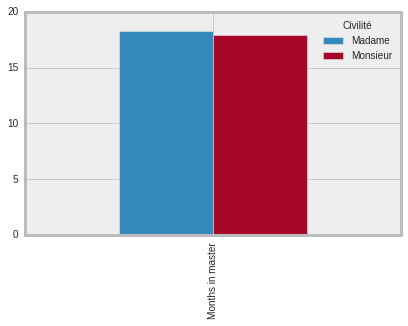

In [344]:
df_m["Civilité"].astype('category')
sex_grouped_master = df_m.groupby('Civilité')['master_months']
m_years = sex_grouped_master.apply(np.average)
m_years.to_frame(name='Months in master').unstack().unstack().plot.bar()

Now we look at the Spécialisation

In [345]:
df_spec = df_m[~pd.isnull(df_m['Spécialisation'])]

In [346]:
df_spec.head(20)

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange,master_months
No Sciper,Nom Prénom,,,,,,,,,,,,,,,
146742,Marx Clément,Monsieur,NaN,NaN,2008.0,2009,2012,NaN,NaN,NaN,2010,2010,"Signals, Images and Interfaces",Présent,NaN,29.0
153066,Aeberhard François-Xavier,Monsieur,NaN,NaN,2007.0,2009,2009,NaN,NaN,NaN,NaN,NaN,Internet computing,Présent,NaN,29.0
154080,Fomene Tierry Alain,Monsieur,NaN,NaN,2007.0,2008,2009,NaN,NaN,NaN,NaN,NaN,Internet computing,Présent,NaN,29.0
154573,Benabdallah Zeineb,Madame,NaN,NaN,2007.0,2008,2009,NaN,NaN,NaN,NaN,2009,Biocomputing,Présent,NaN,35.0
159998,Jesse Julia,Madame,NaN,NaN,2008.0,2008,2009,NaN,NaN,NaN,NaN,NaN,"Signals, Images and Interfaces",Présent,NaN,17.0
160254,Kohler Johann,Monsieur,NaN,NaN,2007.0,2007,2008,NaN,NaN,NaN,NaN,NaN,Internet computing,Présent,NaN,17.0
160718,Copponnex Hadrien,Monsieur,NaN,NaN,2007.0,2007,2008,NaN,NaN,NaN,NaN,NaN,Foundations of Software,Présent,NaN,17.0
160991,Schintgen Joël,Monsieur,NaN,NaN,2007.0,2007,2008,NaN,NaN,NaN,NaN,NaN,Internet computing,Présent,NaN,17.0
161357,Gfeller Sebastian,Monsieur,NaN,NaN,2007.0,2007,2008,NaN,NaN,NaN,NaN,NaN,Foundations of Software,Présent,NaN,17.0


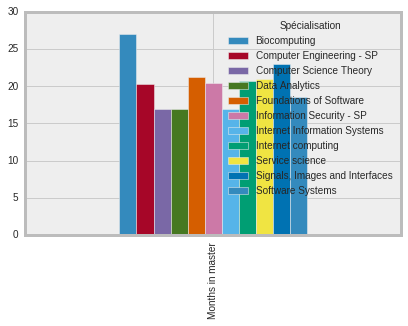

In [347]:
df_spec["Spécialisation"].astype('category')
spec_grouped_master = df_spec.groupby('Spécialisation')['master_months']
m_spec = spec_grouped_master.apply(np.average)
m_spec.to_frame(name='Months in master').unstack().unstack().plot.bar()


## Statistical significance

Once again, we want to evaluate the statistical significance of the difference in means between different populations of our data. In the case of the master's students, we look at the pairwise difference between the general mean time spent doing the master's thesis (in months) and the time spent in each specialisation.

Let's have a look at the general layout to begin with.

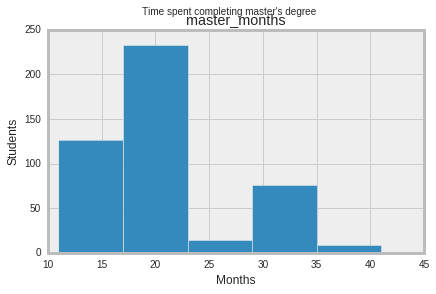

In [348]:
m_months_min = df_m.master_months.min().astype(int)
m_months_max = df_m.master_months.max().astype(int)
df_m.hist(column='master_months', bins=range(m_months_min, m_months_max+1, 6))
pl.suptitle("Time spent completing master's degree")
pl.xlabel("Months")
pl.ylabel("Students")

We can do the same thing for all different specialisations, just to get an idea of the layout of the data.

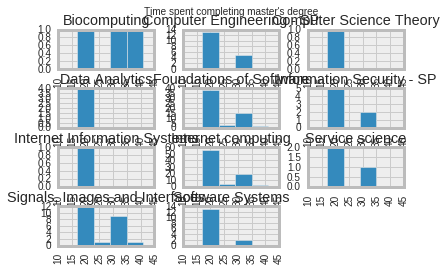

In [349]:
df_m.hist(column='master_months', by=df_m['Spécialisation'], bins=range(m_months_min, m_months_max+1, 6))
pl.suptitle("Time spent completing master's degree")
pl.xlabel("Months")
pl.ylabel("Students")

This doesn't tell us much, but we can already notice that for many of the specialisations, we have very little data available.

### Test 1
As for question 1, we can use the **Mann-Whitney rank test ** on each "general-specialisation" pair to compute the p-value. We store the result of each pairwise Mann-Whitney statistic in a dictionary. 

Once again, we're working with the null hypothesis $H_0$ that the mean in months spent for a master's degree of the two populations is equal.



In [350]:
mann_whitney_res = {}
general_m = df_m['master_months']
for name, value, in spec_grouped_master: 
    stat, pval = stats.mannwhitneyu(general_m, value)
    mann_whitney_res[name] = (stat, pval)

The resulting p-values of the pairwise tests is as follows:

In [351]:
for k, v in mann_whitney_res.items():
    print(k, "has p-value \t", v[1])

Internet Information Systems has p-value 	 0.457431810568
Foundations of Software has p-value 	 1.33096748654e-05
Computer Engineering - SP has p-value 	 0.0192309338083
Internet computing has p-value 	 2.64469080686e-06
Computer Science Theory has p-value 	 0.457431810568
Information Security - SP has p-value 	 0.0914706949436
Software Systems has p-value 	 0.128880174807
Biocomputing has p-value 	 0.0242259206555
Data Analytics has p-value 	 0.413119553178
Signals, Images and Interfaces has p-value 	 0.000147954094661
Service science has p-value 	 0.161655382957


Let's filter out the specialisations so that we keep those with a **p-value of more than 0.10** when compared to the general distribution of students.

In [352]:
P_THRESHOLD = 0.10

filtered_mw_res = {k: v for k, v in mann_whitney_res.items() if v[1] >= P_THRESHOLD}
print("The following specialisations have p-value over", P_THRESHOLD)
print("====================================================")
for k, v in filtered_mw_res.items():
    print(k)

The following specialisations have p-value over 0.1
Internet Information Systems
Computer Science Theory
Service science
Data Analytics
Software Systems


So for all of the above, we fail to reject the null hypothesis $H_0$, meaning that the difference in mean is not obviously statistically significant.

Now let's filter again to keep those with a **p-value of less than 0.10**. 

In [353]:
filtered_mw_res = {k: v for k, v in mann_whitney_res.items() if v[1] < P_THRESHOLD}
print("The following specialisations have p-value below", P_THRESHOLD)
print("====================================================")
for k, v in filtered_mw_res.items():
    print(k)

The following specialisations have p-value below 0.1
Foundations of Software
Computer Engineering - SP
Internet computing
Signals, Images and Interfaces
Information Security - SP
Biocomputing


So for the above specialisations, we reject $H_0$, i.e. the mean of number of months spent for a master's degree in general and for the given specialisation is **not equal**.

### Test 2

Let's run the K-S test on our population pairs again to check for inaccuracies in the Mann-Whitney rank test. 

In [354]:
ks_res = {}
for name, value, in spec_grouped_master: 
    stat, pval = stats.ks_2samp(general_m, value)
    ks_res[name] = (stat, pval)

As before, let's check the resulting p-values for this pairwise testing.

In [355]:
for k, v in ks_res.items():
    print(k, "has p-value \t", v[1])

Internet Information Systems has p-value 	 0.999847450255
Foundations of Software has p-value 	 0.000613571948963
Computer Engineering - SP has p-value 	 0.120460300227
Internet computing has p-value 	 3.81755006311e-05
Computer Science Theory has p-value 	 0.999847450255
Information Security - SP has p-value 	 0.598790100253
Software Systems has p-value 	 0.186128908133
Biocomputing has p-value 	 0.367148191569
Data Analytics has p-value 	 0.8694807381
Signals, Images and Interfaces has p-value 	 0.0591106211244
Service science has p-value 	 0.945266167739


We check which specialisations have a p-value over our defined threshold when compared to the general distribution, i.e. those where we fail to reject $H_0$.

In [356]:
filtered_ks_res = {k: v for k, v in ks_res.items() if v[1] >= P_THRESHOLD}
print("The following specialisations have p-value over", P_THRESHOLD)
print("====================================================")
for k, v in filtered_ks_res.items():
    print(k)

The following specialisations have p-value over 0.1
Internet Information Systems
Computer Engineering - SP
Service science
Computer Science Theory
Information Security - SP
Biocomputing
Data Analytics
Software Systems


And then we check which specialisations have a p-value below our defined threshold when compared to the general distribution, i.e. those for which we reject $H_0$.

In [357]:
filtered_ks_res = {k: v for k, v in ks_res.items() if v[1] < P_THRESHOLD}
print("The following specialisations have p-value below", P_THRESHOLD)
print("====================================================")
for k, v in filtered_ks_res.items():
    print(k)

The following specialisations have p-value below 0.1
Foundations of Software
Signals, Images and Interfaces
Internet computing


There are two specialisations which get different results for the two tests. *Computer Engineering - SP* and *Biocomputing*

### Note on multiple testing
We should note that when using multiple test, we should be adjusting $\alpha$ with a Bonferroni correction so that the probability of observing at least one significant result due to chance remains below the desired significance level. However, this seems to be beyond the scope of this course, so we left it out. We felt it was important to mention this, so that we can take the results of the two tests with a pinch of salt.